# Imports et Settings

In [1]:
import os
import sys
from typing import List

from faker import Faker
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

/tmp/ipykernel_89606/842147316.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Autoriser les imports du répertoire parent
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

In [3]:
from graph_utils import hist_box_plot

# `OrdinalEncoder`

## Principe

Comme son nom l'indique, il sert à **encoder** des variables **ordinales**, c'est à dire des variables **catégorielles** pour lesquelles il existe une **hiérarchie parmi les modalités**.

Par exemple, des tailles de vêtements.

## Données Utilisées

Nous allons générer de la donnée factice que nous allons encoder.

In [4]:
fake = Faker()
Faker.seed(69)
num_entries = 10


fake_sizes = [fake.random_element(elements=('XS', 'S', 'M', 'L', 'XL'))
              for _ in range(num_entries)]

sizes = pd.DataFrame({'size': fake_sizes})
sizes

,size
0,XS
1,XS
2,S
3,XS
4,XL
5,M
6,M
7,XL
8,L
9,L


## Implémentation

In [5]:
from sklearn.preprocessing import OrdinalEncoder

In [6]:
# Lister les modalités par ordre croissant
categories = [["XS", "S", "M", "L", "XL"]]  # ATTENTION: liste de listes!

ord_enc = OrdinalEncoder(categories = categories,
                         # Stratégie en cas de modalité inconnue dans le val ou le test set
                         handle_unknown = "use_encoded_value",
                         # Valeur assignée par défaut à ces modalités inconnues
                         unknown_value = -1)
ord_enc

OrdinalEncoder(categories=[['XS', 'S', 'M', 'L', 'XL']],
               handle_unknown='use_encoded_value', unknown_value=-1)

In [7]:
# Régler l'output du transformer en structures pandas
ord_enc.set_output(transform="pandas")

sizes_tf = ord_enc.fit_transform(sizes)

# Check-out de l'encodage
pd.concat([sizes, sizes_tf], axis=1)

,size,size
0,XS,0.0
1,XS,0.0
2,S,1.0
3,XS,0.0
4,XL,4.0
5,M,2.0
6,M,2.0
7,XL,4.0
8,L,3.0
9,L,3.0


In [8]:
# En cas de modalité inconnue dans les nouvelles données
new_sizes = pd.DataFrame({"size": ["M", "S", "XXL", "L"]})
new_sizes_tf = ord_enc.fit_transform(new_sizes)
pd.concat([new_sizes, new_sizes_tf], axis=1)

,size,size
0,M,2.0
1,S,1.0
2,XXL,-1.0
3,L,3.0


# `FunctionTransformer`

## Principe

Il permet de **transformer les données à l'aide d'une fonction**.

Les principaux use cases sont:
1. **Rectifier la forme d'une distribution** afin qu'elle soit **plus proche d'une distribution normale** (certains algorithmes de Machine Learning fonctionnant mieux avec des données normalement distribuées).
2. **Implémenter une transformation custom**, par exemple **rendre nominale une variable numérique**.

## Données Utilisées

On va illustrer cette partie à l'aide des données du brief "assurance".

In [9]:
# Load insurance data
df = pd.read_csv("data/insurance.csv")

# On sépare les features et la target `charges`
X = df.copy()
y = X.pop("charges")

# On réalise un hold-out classique
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0
)

## Use Case 1

Les options les plus communes pour rendre une distribution plus proche d'une distribution normale sont:
- appliquer une fonction faisant intervenir un **logarithme**,
- appliquer une **racine carrée**.

In [10]:
from sklearn.preprocessing import FunctionTransformer

In [11]:
# Ajouter 1 à des valeurs positives ou nulles évite le cas log(0)
distrib_modifier = FunctionTransformer(lambda x: np.log(1 + x))

In [12]:
# Utiliser des lambdas rend hélas le diagramme peu informatif
distrib_modifier

FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>)

### EDA Rapide

Observons les distributions des colonnes numériques afin de voir si certaines colonnes devraient subir cette transformation.

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1069 entries, 895 to 684
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1069 non-null   int64  
 1   sex       1069 non-null   object 
 2   bmi       1069 non-null   float64
 3   children  1069 non-null   int64  
 4   smoker    1069 non-null   object 
 5   region    1069 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.5+ KB


In [14]:
num_cols = X_train.select_dtypes(exclude="object").columns
num_cols

Index(['age', 'bmi', 'children'], dtype='object')

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


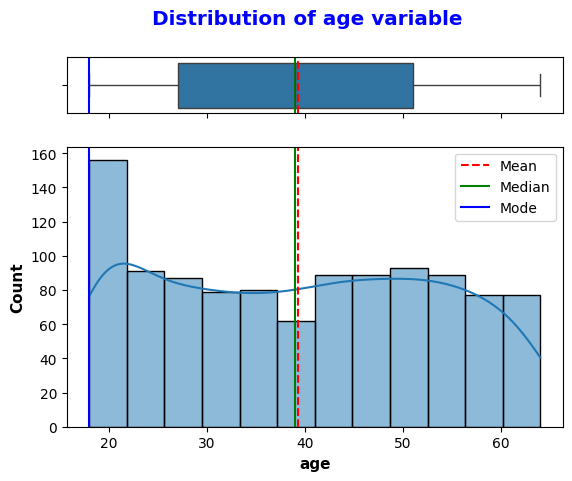

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


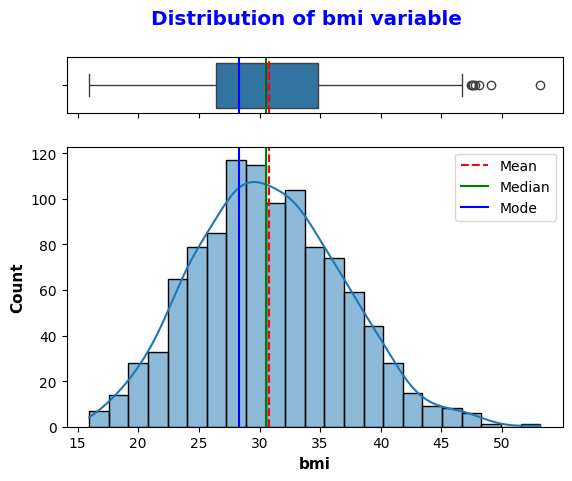

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


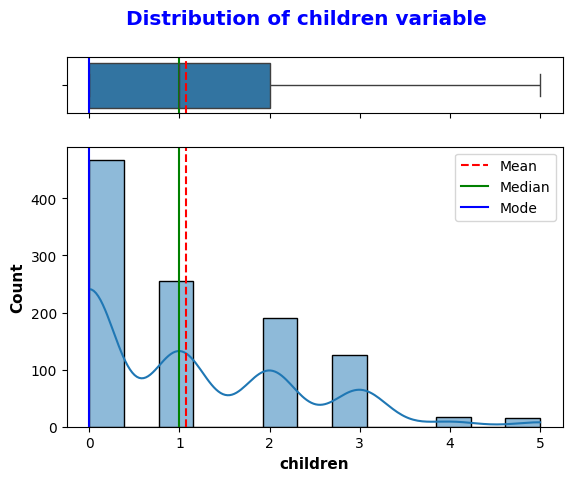

In [15]:
for col in num_cols:
    hist_box_plot(X_train, col)

`bmi` semble distribué normalement, les autres colonnes peuvent bénéficier du transformer.

### Pipeline Numérique

Pour l'illustration, on va ignorer pour le moment les features catégorielles et ne travailler que sur les numériques.

In [16]:
X_train_num = X_train[num_cols]

In [17]:
num_preproc = ColumnTransformer(
    transformers = [
        ('non_normal', distrib_modifier, ['age', 'children'])
    ],
    remainder = "passthrough",  # Le bmi n'est pas concerné par cette étape
    # Pour des noms de colonnes de l'output DataFrame identiques à ceux de l'input
    verbose_feature_names_out = False
)
num_preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('non_normal',
                                 FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                 ['age', 'children'])],
                  verbose_feature_names_out=False)

In [18]:
num_preproc.set_output(transform="pandas")

X_train_num_tf = num_preproc.fit_transform(X_train_num)
X_train_num_tf

,age,children,bmi
895,3.784190,1.098612,20.045
194,2.944439,0.000000,34.430
240,3.178054,1.098612,36.670
1256,4.007333,0.693147,27.645
575,4.077537,0.000000,27.170
...,...,...,...
763,3.828641,1.098612,25.175
835,3.610918,0.000000,31.500
1216,3.401197,1.098612,37.290
559,2.995732,0.000000,35.530


### EDA Post Transformation

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


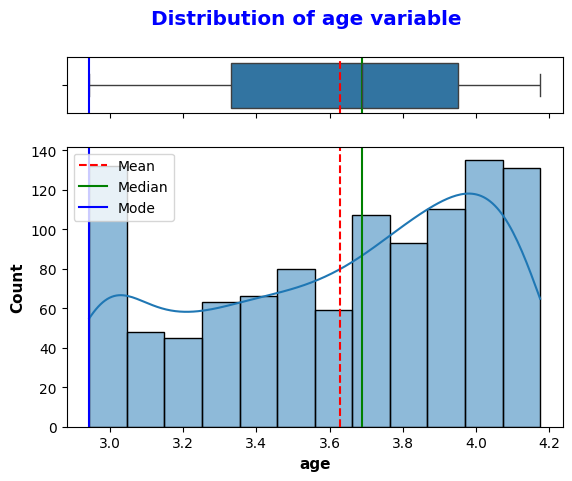

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


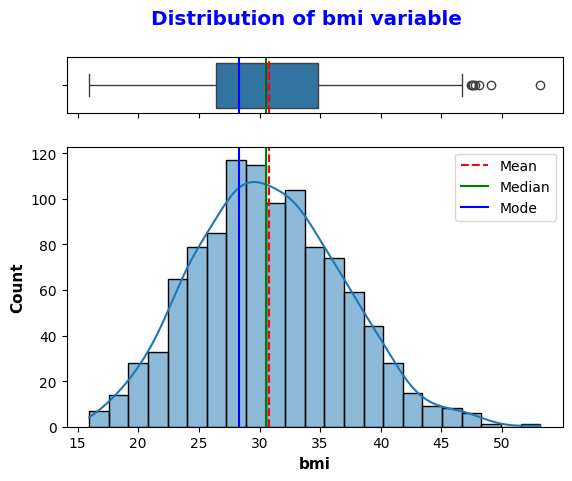

/home/martin/Documents/ML_avance/venv/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


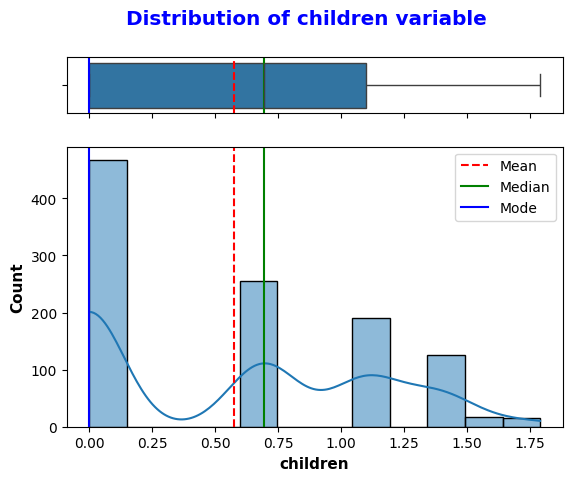

In [19]:
for col in num_cols:
    hist_box_plot(X_train_num_tf, col)

Vous noterez que cela n'a pas vraiment été efficace, mais c'était surtout à titre d'illustration.

## Use Case 2

### Implémentation Basique

Essayons de rendre nominale une variable IMC (`bmi`) du brief assurances.

Pour cela, implémentons une fonction de conversion, qui fera le travail élément par élément.

In [20]:
def bmi_nominalizer(bmi: float) -> str:
    """Transforme un score d'IMC en sa catégorie, définie par l'OMS"""
    if bmi < 18.5:
        return "Underweight"
    if bmi < 25:
        return "Normal Weight"
    if bmi < 30:
        return "Overweight"
    return "Obesity"

In [21]:
bmi_transformer = FunctionTransformer(bmi_nominalizer)

In [22]:
bmi_transformer

FunctionTransformer(func=<function bmi_nominalizer at 0x7f4b00ed5c60>)

In [23]:
bmi_col = X_train.bmi
bmi_col

895     20.045
194     34.430
240     36.670
1256    27.645
575     27.170
         ...  
763     25.175
835     31.500
1216    37.290
559     35.530
684     26.410
Name: bmi, Length: 1069, dtype: float64

In [24]:
# Mais ça ne fonctionne pas...
try:
    bmi_nominalized = bmi_transformer.fit_transform(bmi_col)
except BaseException as e:
    print(type(e), ':', e)

<class 'ValueError'> : The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


En fait, `FunctionTransformer` attend en argument une fonction **vectorielle**, on va donc adapter la fonction précédente.

In [25]:
def bmi_nominalizer_vect(bmis: 'array-like') -> np.array:
    """Version vectorielle de bmi_nominalizer"""
    return np.array([bmi_nominalizer(bmi) for bmi in bmis])

In [26]:
bmi_transformer = FunctionTransformer(bmi_nominalizer_vect)

In [27]:
bmi_transformer

FunctionTransformer(func=<function bmi_nominalizer_vect at 0x7f4b0116ab00>)

In [28]:
bmi_nominalized = bmi_transformer.fit_transform(bmi_col)

In [29]:
bmi_nominalized

array(['Normal Weight', 'Obesity', 'Obesity', ..., 'Obesity', 'Obesity',
       'Overweight'], dtype='<U13')

#### Adaptation du Pipeline

Il faut repenser l'intégralité du pipeline.

Ce qui suit est un "template" (un peu "overkill" vu le peu de colonnes...) réutilisable, qui apparie explicitement les colonnes et leur transformer dans le `ColumnTransformer`

NB: Les arguments de `OneHotEncoder` spécifiés ci-dessous sont évoqués en fin de Notebook.

In [30]:
num_cols = ['age', 'children']  # On retire `bmi`
nom_cols = ['region']  # Variable Nominale
bin_cols = ['sex', 'smoker']  # Variables binaires

ohe_nom = OneHotEncoder(handle_unknown="ignore",
                        sparse_output=False)

ohe_bin = OneHotEncoder(drop="if_binary",
                        handle_unknown="ignore",
                        sparse_output=False)

std_scl = StandardScaler()

step1 = ColumnTransformer(
    transformers =  [
        ("num", distrib_modifier, num_cols),
        ("nom", ohe_nom, nom_cols),
        ("bin", ohe_bin, bin_cols),
        ("bmi", bmi_transformer, ["bmi"])
    ],
    verbose_feature_names_out = False
)

preproc = make_pipeline(step1, std_scl)
preproc    

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                                  ['age', 'children']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['region']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker']),
                                                 ('bmi',
                                                  FunctionTransformer(func=<function bmi_nominalizer_vect at 0x7f4b0116ab00>),
                                                  ['bmi'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler())])

**Mais là, c'est le drame...**

In [31]:
preproc.set_output(transform="pandas")

try:
    X_train_tf = preproc.fit_transform(X_train)
    X_train_tf
except BaseException as e:
    print(type(e), ':', e)

<class 'TypeError'> : '<' not supported between instances of 'str' and 'float'


#### Recommandation Finale

Evitez d'utiliser `FunctionTransformer` avec vos propres fonctions, notamment si elles transtypent des colonnes.

**Une alternative plus robuste et plus flexible existe, opter pour la POO**.

### Implémentation avec une Classe

Afin de régler le problème précédent, on peut envisager d'**implémenter ses propres transformers sous forme de classes**.

Il faut alors les faire hériter de:
- `BaseEstimator`,
- `TransformerMixin`

Voici un template pour un transformer *stateless*, c'est à dire qui n'a pas besoin de stocker d'informations sur le *train set* en vue de les utiliser pour l'étape *transform*, i.e. qui n'a pas besoin de `fit` implémenté.

```python
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, *args, **kwargs):
        # Implémentez l'initialisation
        ...

    def fit(self, X, y=None):
        # Pas de fit nécessaire, on renvoie juste l'instance en cours
        return self

    def transform(self, X):
        # Implémentez votre transformation
        ...

    # D'autres implémentations sont parfois nécessaires, comme get_feature_names_out
```

Voici comment pourrait être implémentée une classe transformant le `bmi`:

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

In [33]:
class BmiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, bins: List[float], labels=List[str]):
        self.column = column
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        # Pas de fit nécessaire pour ce transformer
        return self

    def transform(self, X):
        if self.column in X.columns:
            X_binned = pd.cut(X[self.column],
                              bins=self.bins, labels=self.labels,
                              right=False)  # Pour inclure la valeur inf, pas la valeur sup
            X_transformed = X.copy()
            X_transformed[self.column] = X_binned
            return X_transformed
        else:
            raise ValueError(f"Column {self.column} not in input")

    def get_feature_names_out(self, input_features=None):
        return [self.column]

#### Intégration dans le Pipeline

In [34]:
bmi_edges = [0.0, 25.0, 30.0, np.inf]
bmi_cats = ["underweight_normal", "overweight", "obesity"]

bmi_cat = BmiTransformer(column="bmi", bins=bmi_edges, labels=bmi_cats) 
bmi_pip = make_pipeline(bmi_cat, ohe_nom)

step1 = ColumnTransformer(
    transformers =  [
        ("num", distrib_modifier, num_cols),
        ("nom", ohe_nom, nom_cols),
        ("bin", ohe_bin, bin_cols),
        ("bmi", bmi_pip, ["bmi"])
    ],
    verbose_feature_names_out = False
)

preproc = make_pipeline(step1, std_scl)
preproc    

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                                  ['age', 'children']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['region']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker']),
                                                 ('bmi',
                                                  Pipeline(steps=[('bmitransformer',
                                                                   BmiTransformer(bins=[0.0,
                                                                                        25.0,
                                                                                        30.0,
                                                                                        inf],
                                                                                  column='bmi',
                                                                                  labels=['underweight_normal',
                                                                                          'overweight',
                                                                                          'obesity'])),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['bmi'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler())])

In [35]:
preproc.set_output(transform="pandas")

X_train_tf = preproc.fit_transform(X_train)
X_train_tf

,age,children,region_northeast,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes,bmi_obesity,bmi_overweight,bmi_underweight_normal
895,0.410027,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,1.987228,-1.070788,-0.634734,2.144029
194,-1.798512,-1.027870,-0.561144,-0.568348,1.662554,-0.578430,1.010343,-0.503214,0.933892,-0.634734,-0.466412
240,-1.184106,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,1.987228,0.933892,-0.634734,-0.466412
1256,0.996893,0.214560,-0.561144,1.759484,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,1.575463,-0.466412
575,1.181530,-1.027870,-0.561144,1.759484,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,1.575463,-0.466412
...,...,...,...,...,...,...,...,...,...,...,...
763,0.526935,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,1.575463,-0.466412
835,-0.045677,-1.027870,-0.561144,-0.568348,-0.601484,1.728816,1.010343,-0.503214,0.933892,-0.634734,-0.466412
1216,-0.597240,0.941335,-0.561144,-0.568348,1.662554,-0.578430,1.010343,-0.503214,0.933892,-0.634734,-0.466412
559,-1.663611,-1.027870,-0.561144,1.759484,-0.601484,-0.578430,1.010343,-0.503214,0.933892,-0.634734,-0.466412


#### Avertissements pour la Sérialisation

Il reste des éléments à souligner quand vous implémentez vos propres transformers, si vous souhaitez sérialiser votre modèle via un package comme `joblib`...

- Il pourra être nécessaire d'implémenter `get_feature_names_out` (mais c'est, en tout état de cause, un outil de diagnostic et de débug)
- Il faudra sortir du paradigme notebook afin de **réaliser tout le workflow dans un script Python**.
- Il faudra aussi **isoler vos classes dans un module dédié**, et **importer ce module dans votre script**.

#### Aller Plus Loin: Transformers *Stateful*

Pour ces transformers, il est nécessaire d'implémenter une méthode `fit` qui permette d'extraire du *train set* les informations nécessaires pour réaliser l'étape `transform`.

Ceci dépassant le cadre de ce Notebook, voici un lien vers l'implémentation d'un transformer stateful, dans le cadre du NLP.

# Composants Additionnels

Après ce préprocessing, on peut envisager, avant de conclure par l'estimateur en queue de pipeline, d'ajouter d'autres composants...

## `PolynomialFeatures`

Afin de croiser les variables par multiplication et ainsi d'en créer des nouvelles.

In [36]:
poly = PolynomialFeatures(degree=2)

In [37]:
preproc_poly = make_pipeline(preproc, poly)
preproc_poly

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                                                   ['age',
                                                                    'children']),
                                                                  ('nom',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['region']),
                                                                  ('bin',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['se...
                                                                  ('bmi',
                                                                   Pipeline(steps=[('bmitransformer',
                                                                                    BmiTransformer(bins=[0.0,
                                                                                                         25.0,
                                                                                                         30.0,
                                                                                                         inf],
                                                                                                   column='bmi',
                                                                                                   labels=['underweight_normal',
                                                                                                           'overweight',
                                                                                                           'obesity'])),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['bmi'])],
                                                    verbose_feature_names_out=False)),
                                 ('standardscaler', StandardScaler())])),
                ('polynomialfeatures', PolynomialFeatures())])

In [38]:
preproc_poly.set_output(transform="pandas")

X_train_tf = preproc_poly.fit_transform(X_train)
X_train_tf

,1,age,children,region_northeast,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes,bmi_obesity,...,smoker_yes^2,smoker_yes bmi_obesity,smoker_yes bmi_overweight,smoker_yes bmi_underweight_normal,bmi_obesity^2,bmi_obesity bmi_overweight,bmi_obesity bmi_underweight_normal,bmi_overweight^2,bmi_overweight bmi_underweight_normal,bmi_underweight_normal^2
895,1.0,0.410027,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,1.987228,-1.070788,...,3.949074,-2.127899,-1.261361,4.260673,1.146586,0.679665,-2.295800,0.402887,-1.360888,4.596859
194,1.0,-1.798512,-1.027870,-0.561144,-0.568348,1.662554,-0.578430,1.010343,-0.503214,0.933892,...,0.253224,-0.469947,0.319407,0.234705,0.872154,-0.592773,-0.435578,0.402887,0.296047,0.217540
240,1.0,-1.184106,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,1.987228,0.933892,...,3.949074,1.855856,-1.261361,-0.926866,0.872154,-0.592773,-0.435578,0.402887,0.296047,0.217540
1256,1.0,0.996893,0.214560,-0.561144,1.759484,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,...,0.253224,0.538835,-0.792795,0.234705,1.146586,-1.686987,0.499428,2.482085,-0.734815,0.217540
575,1.0,1.181530,-1.027870,-0.561144,1.759484,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,...,0.253224,0.538835,-0.792795,0.234705,1.146586,-1.686987,0.499428,2.482085,-0.734815,0.217540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.0,0.526935,0.941335,1.782072,-0.568348,-0.601484,-0.578430,-0.989762,-0.503214,-1.070788,...,0.253224,0.538835,-0.792795,0.234705,1.146586,-1.686987,0.499428,2.482085,-0.734815,0.217540
835,1.0,-0.045677,-1.027870,-0.561144,-0.568348,-0.601484,1.728816,1.010343,-0.503214,0.933892,...,0.253224,-0.469947,0.319407,0.234705,0.872154,-0.592773,-0.435578,0.402887,0.296047,0.217540
1216,1.0,-0.597240,0.941335,-0.561144,-0.568348,1.662554,-0.578430,1.010343,-0.503214,0.933892,...,0.253224,-0.469947,0.319407,0.234705,0.872154,-0.592773,-0.435578,0.402887,0.296047,0.217540
559,1.0,-1.663611,-1.027870,-0.561144,1.759484,-0.601484,-0.578430,1.010343,-0.503214,0.933892,...,0.253224,-0.469947,0.319407,0.234705,0.872154,-0.592773,-0.435578,0.402887,0.296047,0.217540


## Feature Selection

L'étape précédente a l'inconvénient de souvent faire exploser le nombre de variables.

On peut alors **contrebalancer** cela en ajoutant une étape utilisant **transformers permettant de faire de la feature selection**, ce qui vous sera présenté dans un autre module.

Lien vers la [**documentation du module dédié de Scikit-Learn**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

# Quelques Tips Supplémentaires

Cette section résume quelques tips utiles à connaître... Parfois déjà rencontrés précédemment et expliqués brièvement ou pas.

## `OneHotEncoder`: quelques paramètres

Tous les encodages nominaux, y compris binaires, peuvent être réalisés avec `OneHotEncoder`, ce qui en fait le *"one encoder to rule them all"* pour cette tâche.

### `drop`

- **Pour un encodage binaire** (i.e. *avec une seule colonne en output*), spécifier: `drop="if_binary"`.
- Ce même paramètre **peut servir à limiter l'explosion du nombre de colonnes si vous avez beaucoup de variables nominales**.
  Ainsi, une variable nominale avec $N$ modalités peut être encodée sur $N - 1$ colonnes. Il suffit de considérer que, dès que la $N$ème modalité sera rencontrée, les $N-1$ colonnes ne contiendront que des zéros.
  L'**inconvénient** de cette démarche est que **vous perdez une colonne par feature, pour une interprétation à postériori**.

### `handle_unknown`

Il spécifie **la manière dont le transformer va gérer des modalités qu'il n'a pas encore rencontrées**.

- `handle_unknown='ignore'` est un filet de sécurité non implémenté par défault, le comportement par défaut `'error'` entraînant la levée d'une erreur.
- Une dernière option `infrequent_if_exist`, plus complexe, est laissée à la curiosité du lecteur.

### `sparse_output`

Par défaut réglé sur `True`, il génère logiquement des conflits avec `transformer.set_output(transform='pandas'`), quand vous inspectez votre pipeline.

## `ColumnTransformer`: quelques paramètres

### `remainder='passthrough'`

Permet de ne pas appliquer de traitement aux colonnes non sélectionnées.

### `verbose_feature_names_out = False`

Permet d'éviter que `ColumnTransformer`, dans son output, ne préfixe tous les noms des features d'origine par le transformer qui leur a été appliqué, et donc permet un output plus concis.

## Les Pipelines Sont Indexables

Et donc vous pouvez:
- les indexer,
- les slicer...

pour accéder à un élément spécifique, ce qui est pratique pour du débug.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

In [49]:
k_bests = SelectKBest(k=12)
lin_reg = LinearRegression()

In [50]:
full_pipe = make_pipeline(preproc_poly, k_bests, lin_reg)

full_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('columntransformer',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                                                                    ['age',
                                                                                     'children']),
                                                                                   ('nom',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False),
                                                                                    ['region']),
                                                                                   ('bin',
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  handle_unknown='ignor...
                                                                                                                    column='bmi',
                                                                                                                    labels=['underweight_normal',
                                                                                                                            'overweight',
                                                                                                                            'obesity'])),
                                                                                                    ('onehotencoder',
                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                   sparse_output=False))]),
                                                                                    ['bmi'])],
                                                                     verbose_feature_names_out=False)),
                                                  ('standardscaler',
                                                   StandardScaler())])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('selectkbest', SelectKBest(k=12)),
                ('linearregression', LinearRegression())])

In [51]:
len(full_pipe)

3

In [53]:
full_pipe[-1]

LinearRegression()

**On peut retirer l'estimateur pour inspecter le résultat du `fit_transform` pour tout le reste**.

In [59]:
full_pipe[:-1]

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('columntransformer',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                                                                    ['age',
                                                                                     'children']),
                                                                                   ('nom',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False),
                                                                                    ['region']),
                                                                                   ('bin',
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  handle_unknown='ignor...
                                                                                                     BmiTransformer(bins=[0.0,
                                                                                                                          25.0,
                                                                                                                          30.0,
                                                                                                                          inf],
                                                                                                                    column='bmi',
                                                                                                                    labels=['underweight_normal',
                                                                                                                            'overweight',
                                                                                                                            'obesity'])),
                                                                                                    ('onehotencoder',
                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                   sparse_output=False))]),
                                                                                    ['bmi'])],
                                                                     verbose_feature_names_out=False)),
                                                  ('standardscaler',
                                                   StandardScaler())])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('selectkbest', SelectKBest(k=12))])

In [60]:
full_pipe[0][-1]

PolynomialFeatures()

In [57]:
full_pipe[0][0][0]

ColumnTransformer(transformers=[('num',
                                 FunctionTransformer(func=<function <lambda> at 0x7f4b0568ca60>),
                                 ['age', 'children']),
                                ('nom',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['region']),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex', 'smoker']),
                                ('bmi',
                                 Pipeline(steps=[('bmitransformer',
                                                  BmiTransformer(bins=[0.0,
                                                                       25.0,
                                                                       30.0,
                                                                       inf],
                                                                 column='bmi',
                                                                 labels=['underweight_normal',
                                                                         'overweight',
                                                                         'obesity'])),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['bmi'])],
                  verbose_feature_names_out=False)

Il n'en est pas de même pour `ColumnTransformer`

In [46]:
try:
    preproc_poly[0][0][-1]
except BaseException as e:
    print(type(e), ':', e)

<class 'TypeError'> : 'ColumnTransformer' object is not subscriptable
